Notebook for adversarial training

Actually, "adversarial" might not be the best word here as IPDs are not zero-summed.

Training in a static environment might be similar to playing chess against bots (before AlphaGo is born I guess), where you might be able to exploit its pattern/rigidness to win the games without completely master chess. On the other hand, playing against other human is much harder, because there is no fixed pattern to exploit, so you have to learn deeper the art of chess. This is the core idea of this notebook.

I'd expect the DQNs to learn better in this dynamic environment compared to stage 2. The opponent can now exploit their behavior, which should force the neural networks to learn to 
1. cooperate if possible, to gain more reward
2. penalize the opponent for defection, to avoid getting (0,5)

Yes, in theory they should be able to converge to TitForTat (proved optimal strategy => global optimal in our gradient) here, given sufficient training against each other.

questions to observe:
- will they converge?
if so,
- how do they treat the last turns? cooperate or defect?
- what makes them to converge quicker?
- tounorment score?
- weights?
- does the Q-value fit to theoritical ones?

if not,
- where do they end up?
- what seem to prevent them from converge?

In [1]:
# colab setup
# ignore this cell if training on local machine

from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/The-Evolution-of-Defection/"

import sys
sys.path.append(path)

%pip install --ignore-installed PyYAML
%pip install axelrod

Mounted at /content/drive/
     |████████████████████████████████| 596 kB 7.1 MB/s 
     |████████████████████████████████| 205 kB 8.8 MB/s 
     |████████████████████████████████| 125 kB 54.0 MB/s 
     |████████████████████████████████| 374 kB 46.0 MB/s 
  Created wheel for axelrod: filename=Axelrod-4.11.0-py2.py3-none-any.whl size=191320 sha256=708436849cb2f49ad1cafb4e2cf754aaaf4084c209151b0487183cefbbfbea39
  Stored in directory: /root/.cache/pip/wheels/a4/10/82/a6ba5a92333eac725364ac55da628c4a385b767616d1138ee8
Successfully built axelrod
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [2]:
%load_ext autoreload
%autoreload 2

import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from copy import deepcopy
from pprint import pprint
#from itertools import groupby, permutations

np.set_printoptions(precision=3)

In [4]:
# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import set_match, set_play

In [12]:
GAME_LEN = 20 + 1
C = axl.Action.C
D = axl.Action.D
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [28]:
dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            ReplayMemory(4000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN), name='DQN1')

dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            ReplayMemory(4000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn, State(GAME_LEN), name='DQN2')
del dqn
gc.collect()

param1 = {"lr": 3e-5, 'batch': 32, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
      'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}
param2 = deepcopy(param1)

In [29]:
from axl_utils.tournament import Tournament
tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
results = tournament.play()
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

Analysing: 100%|██████████| 25/25 [00:00<00:00, 153.74it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,NNplayer,3.25,0.55,1.0,0.0,0.4,0.15,0.40,0.05,0.714286,0.666667,0.375,1.0
1,1,NNplayer,2.00,0.80,0.0,1.0,0.4,0.40,0.15,0.05,0.714286,0.875000,1.000,0.0


In [30]:
[Match((p1, p2)).play() for _ in range(200)]

ls = []
greedy = (0.9, 0.2, 9) # const, lower bound, scale factor
# greedy will decay in (const ** (iteration) + lower bound) / scale factor

for i in range(1, 100):

    if i % 2 == 0:
      # test in tournament
      with p1:
        with p2:
          p1.network.verbosity = p2.network.verbosity = False
          tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
          results = tournament.play()
          summary = pd.DataFrame(map(list, results.summarise()), columns=headers)
          ls.append(summary)

      print(summary)

      # save
      with open(path+'data/s3/tn_results.pkl', "wb") as file:
          dill.dump(ls, file)
      with open(path+f'data/s3/p1_{i}.pkl', "wb") as file:
          dill.dump(p1, file)
      with open(path+f'data/s3/p2_{i}.pkl', "wb") as file:
          dill.dump(p2, file)

    print(f'--------Iter {i}--------')
    start = time()

    # get experience
    [Match((p1, p2)).play() for _ in range(160)] # 80% of replay
    
    # train
    print("--------training p1--------")
    for _ in range(5):
      p1.train(100, param1, loss_targ=0.02)
      print(p1.network.loss)
    print("--------training p2--------")
    for _ in range(5):
      p2.train(100, param2, loss_targ=0.02)
      print(p2.network.loss)
    
    #param['lr'] *= 0.9
    p1.greedy = p2.greedy = (greedy[0] ** i + greedy[1]) / greedy[2]
    print(f"+ {time() - start:.2f} sec")

--------Iter 1--------
--------training p1--------
terminated at 58 epochs
[0.652 0.941]
terminated at 37 epochs
[0.657 0.758]
[0.576 0.733]
terminated at 80 epochs
[0.636 0.685]
[0.464 0.443]
--------training p2--------
terminated at 46 epochs
[0.492 0.643]
[0.484 0.744]
terminated at 60 epochs
[0.468 0.603]
terminated at 34 epochs
[0.478 0.689]
terminated at 79 epochs
[0.449 0.591]
+ 375.63 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 107.67it/s]


--------Iter 2--------
--------training p1--------
terminated at 41 epochs
[0.805 0.937]
[0.543 0.695]
terminated at 60 epochs
[0.462 0.634]
terminated at 40 epochs
[0.439 0.587]
[0.392 0.524]
--------training p2--------
terminated at 41 epochs
[0.796 1.179]
terminated at 51 epochs
[0.668 0.948]
terminated at 49 epochs
[0.552 0.859]
terminated at 39 epochs
[0.596 0.753]
terminated at 50 epochs
[0.525 0.774]
+ 303.23 sec
--------Iter 3--------
--------training p1--------
terminated at 54 epochs
[0.865 1.102]
terminated at 34 epochs
[0.762 0.921]
terminated at 42 epochs
[0.68  0.759]
[0.459 0.504]
terminated at 34 epochs
[0.494 0.539]
--------training p2--------
terminated at 37 epochs
[0.998 1.203]
terminated at 62 epochs
[0.701 0.901]
terminated at 45 epochs
[0.662 0.726]
terminated at 53 epochs
[0.53  0.632]
terminated at 49 epochs
[0.509 0.576]
+ 276.49 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 133.74it/s]


--------Iter 4--------
--------training p1--------
terminated at 82 epochs
[0.561 0.672]
terminated at 57 epochs
[0.495 0.705]
[0.334 0.479]
terminated at 46 epochs
[0.376 0.568]
terminated at 70 epochs
[0.363 0.452]
--------training p2--------
terminated at 87 epochs
[0.791 0.764]
terminated at 57 epochs
[0.637 0.673]
terminated at 75 epochs
[0.562 0.593]
terminated at 36 epochs
[0.595 0.619]
terminated at 59 epochs
[0.484 0.53 ]
+ 352.87 sec
--------Iter 5--------
--------training p1--------
terminated at 52 epochs
[0.958 1.19 ]
terminated at 86 epochs
[0.662 0.72 ]
terminated at 59 epochs
[0.653 0.7  ]
terminated at 48 epochs
[0.589 0.716]
terminated at 46 epochs
[0.575 0.662]
--------training p2--------
terminated at 51 epochs
[1.024 1.028]
terminated at 35 epochs
[1.143 1.018]
terminated at 60 epochs
[0.746 0.725]
terminated at 60 epochs
[0.586 0.647]
[0.321 0.487]
+ 320.34 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 115.65it/s]


--------Iter 6--------
--------training p1--------
terminated at 38 epochs
[1.098 1.356]
terminated at 42 epochs
[0.76  1.055]
terminated at 53 epochs
[0.681 0.849]
terminated at 38 epochs
[0.615 0.732]
[0.472 0.678]
--------training p2--------
terminated at 38 epochs
[1.123 1.268]
terminated at 39 epochs
[0.795 0.802]
terminated at 34 epochs
[0.695 0.727]
terminated at 37 epochs
[0.548 0.667]
[0.369 0.412]
+ 275.48 sec
--------Iter 7--------
--------training p1--------
terminated at 49 epochs
[0.964 1.074]
terminated at 75 epochs
[0.681 0.806]
[0.5   0.696]
terminated at 45 epochs
[0.615 0.693]
[0.412 0.523]
--------training p2--------
terminated at 67 epochs
[0.784 0.796]
terminated at 71 epochs
[0.544 0.592]
terminated at 42 epochs
[0.518 0.641]
[0.253 0.47 ]
terminated at 48 epochs
[0.326 0.479]
+ 368.75 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 118.87it/s]


--------Iter 8--------
--------training p1--------
terminated at 65 epochs
[0.888 1.027]
terminated at 52 epochs
[0.673 0.789]
terminated at 41 epochs
[0.719 0.743]
[0.396 0.504]
terminated at 56 epochs
[0.466 0.455]
--------training p2--------
terminated at 73 epochs
[0.845 0.701]
[0.515 0.529]
terminated at 52 epochs
[0.488 0.537]
[0.341 0.477]
terminated at 51 epochs
[0.352 0.46 ]
+ 366.80 sec
--------Iter 9--------
--------training p1--------
[0.919 0.739]
terminated at 39 epochs
[1.046 0.784]
terminated at 94 epochs
[0.672 0.437]
terminated at 44 epochs
[0.655 0.488]
[0.744 0.522]
--------training p2--------
terminated at 35 epochs
[0.932 1.164]
terminated at 41 epochs
[0.72  0.759]
[0.321 0.329]
[0.242 0.281]
[0.367 0.379]
+ 399.54 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 114.67it/s]


--------Iter 10--------
--------training p1--------
terminated at 49 epochs
[1.085 1.007]
terminated at 40 epochs
[0.835 0.836]
terminated at 45 epochs
[0.687 0.693]
terminated at 53 epochs
[0.592 0.547]
terminated at 58 epochs
[0.454 0.453]
--------training p2--------
terminated at 54 epochs
[0.827 0.958]
terminated at 77 epochs
[0.464 0.516]
terminated at 50 epochs
[0.476 0.589]
[0.356 0.345]
terminated at 49 epochs
[0.347 0.346]
+ 314.19 sec
--------Iter 11--------
--------training p1--------
terminated at 46 epochs
[1.023 1.002]
terminated at 47 epochs
[0.624 0.711]
[0.381 0.403]
terminated at 34 epochs
[0.444 0.473]
terminated at 38 epochs
[0.426 0.465]
--------training p2--------
terminated at 34 epochs
[0.894 1.027]
terminated at 74 epochs
[0.559 0.583]
terminated at 66 epochs
[0.555 0.554]
terminated at 63 epochs
[0.529 0.449]
terminated at 41 epochs
[0.421 0.436]
+ 296.00 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 131.48it/s]


--------Iter 12--------
--------training p1--------
terminated at 43 epochs
[0.875 1.121]
terminated at 47 epochs
[0.579 0.764]
terminated at 37 epochs
[0.544 0.609]
terminated at 67 epochs
[0.37  0.508]
terminated at 40 epochs
[0.398 0.539]
--------training p2--------
terminated at 39 epochs
[1.107 0.998]
terminated at 70 epochs
[0.653 0.729]
terminated at 36 epochs
[0.617 0.657]
terminated at 42 epochs
[0.572 0.563]
[0.317 0.393]
+ 286.12 sec
--------Iter 13--------
--------training p1--------
terminated at 35 epochs
[0.995 1.11 ]
terminated at 41 epochs
[0.813 0.864]
terminated at 42 epochs
[0.628 0.735]
terminated at 70 epochs
[0.538 0.602]
terminated at 73 epochs
[0.578 0.514]
--------training p2--------
terminated at 43 epochs
[0.855 1.005]
terminated at 44 epochs
[0.667 0.787]
terminated at 75 epochs
[0.489 0.557]
[0.415 0.503]
terminated at 34 epochs
[0.492 0.579]
+ 309.81 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 131.24it/s]


--------Iter 14--------
--------training p1--------
terminated at 44 epochs
[1.138 1.308]
terminated at 48 epochs
[1.083 1.037]
terminated at 48 epochs
[0.967 0.948]
terminated at 58 epochs
[0.785 0.721]
terminated at 49 epochs
[0.69  0.635]
--------training p2--------
terminated at 65 epochs
[0.867 0.82 ]
terminated at 77 epochs
[0.591 0.507]
terminated at 59 epochs
[0.506 0.507]
terminated at 38 epochs
[0.591 0.567]
terminated at 61 epochs
[0.459 0.489]
+ 304.31 sec
--------Iter 15--------
--------training p1--------
terminated at 45 epochs
[1.125 1.14 ]
[0.537 0.476]
terminated at 66 epochs
[0.466 0.475]
terminated at 39 epochs
[0.573 0.549]
[0.436 0.397]
--------training p2--------
terminated at 74 epochs
[0.843 0.864]
[0.538 0.698]
[0.462 0.644]
[0.366 0.52 ]
terminated at 88 epochs
[0.365 0.605]
+ 451.63 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 122.13it/s]


--------Iter 16--------
--------training p1--------
terminated at 83 epochs
[0.61  0.741]
terminated at 51 epochs
[0.741 0.851]
terminated at 56 epochs
[0.674 0.63 ]
terminated at 37 epochs
[0.572 0.592]
terminated at 67 epochs
[0.441 0.468]
--------training p2--------
terminated at 38 epochs
[1.199 0.989]
terminated at 42 epochs
[0.888 0.799]
terminated at 79 epochs
[0.707 0.601]
terminated at 81 epochs
[0.488 0.47 ]
[0.43  0.428]
+ 361.60 sec
--------Iter 17--------
--------training p1--------
terminated at 56 epochs
[0.842 0.994]
terminated at 79 epochs
[0.48  0.613]
terminated at 42 epochs
[0.515 0.609]
terminated at 53 epochs
[0.498 0.608]
[0.343 0.453]
--------training p2--------
terminated at 46 epochs
[0.922 0.987]
terminated at 46 epochs
[0.69  0.752]
terminated at 36 epochs
[0.621 0.654]
[0.554 0.499]
terminated at 77 epochs
[0.418 0.386]
+ 369.09 sec


Analysing: 100%|██████████| 25/25 [00:00<00:00, 114.84it/s]


--------Iter 18--------
--------training p1--------
terminated at 41 epochs
[1.03  1.139]
terminated at 37 epochs
[0.929 1.167]
terminated at 42 epochs
[0.755 0.854]
terminated at 70 epochs
[0.594 0.692]
terminated at 78 epochs
[0.597 0.674]
--------training p2--------
terminated at 42 epochs
[0.864 0.916]
terminated at 48 epochs
[0.677 0.699]
[0.474 0.451]
terminated at 68 epochs
[0.413 0.382]
[0.404 0.316]
+ 368.75 sec
--------Iter 19--------
--------training p1--------
terminated at 49 epochs
[1.203 1.343]
terminated at 41 epochs
[0.913 1.108]
terminated at 44 epochs
[0.757 0.855]
terminated at 49 epochs
[0.648 0.681]


KeyboardInterrupt: ignored

In [33]:
with p1:
  with p2:
    play(p1, p2)

[[27.19  26.296]]
[[22.713 20.358]]
[[25.921 25.347]]
[[20.426 22.476]]
[[23.518 25.245]]
[[24.248 22.574]]
[[27.296 23.939]]
[[21.836 22.108]]
[[22.551 28.216]]
[[31.844 25.845]]
[[22.011 25.76 ]]
[[26.304 20.125]]
[[19.585 20.6  ]]
[[26.229 22.394]]
[[16.111 16.475]]
[[17.449 22.509]]
[[16.975 18.392]]
[[17.568 13.799]]
[[15.976 16.636]]
[[20.695 22.411]]
[[13.807 15.729]]
[[14.431 17.2  ]]
[[13.94  15.967]]
[[8.77 8.13]]
[[12.848 13.147]]
[[16.474 16.708]]
[[16.226 10.051]]
[[ 9.108 10.149]]
[[10.483 12.325]]
[[6.843 5.853]]
[[8.081 5.345]]
[[6.177 3.637]]
[[ 9.052 10.453]]
[[4.639 3.21 ]]
[[3.896 4.05 ]]
[[2.553 9.84 ]]
[[4.102 5.414]]
[[0.347 1.505]]
[[0.212 2.735]]
[[ 0.502 -1.69 ]]
[[-0.568 -2.857]]
[[-0.795  0.41 ]]
[(3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (5, 0), (5, 0), (1, 1), (5, 0), (1, 1), (1, 1), (5, 0), (1, 1), (0, 5), (5, 0), (3, 3), (5, 0), (1, 1), (1, 1), (5, 0)]
Player 1 score = 57
Player 2 score = 27


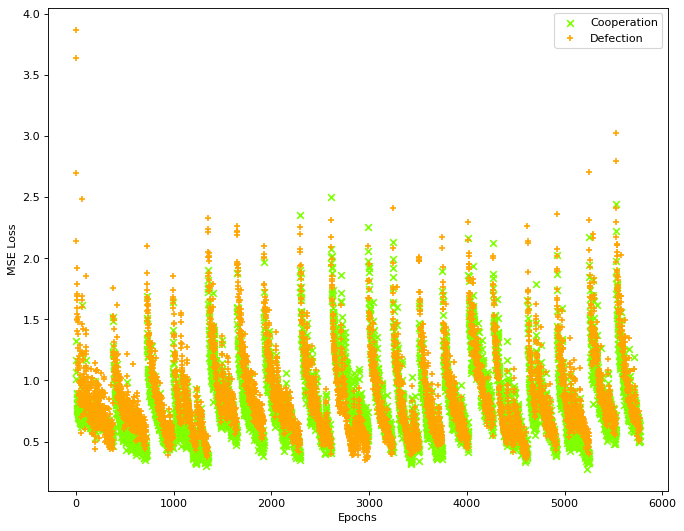

In [31]:
p1.plot()

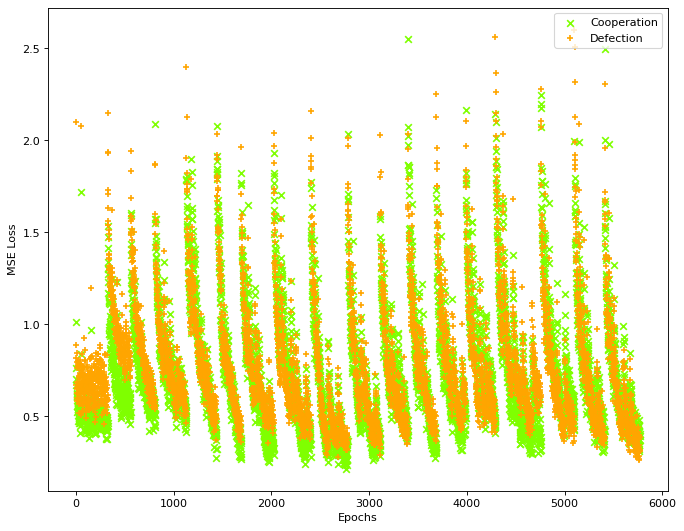

In [34]:
p2.plot()

In [35]:
ls

[   Rank      Name  Median_score  ...  CD_to_C_rate  DC_to_C_rate  DD_to_C_rate
 0     0  NNplayer           2.7  ...         0.000         0.125           0.0
 1     1  NNplayer           0.7  ...         0.375         0.000           0.5
 
 [2 rows x 14 columns],
    Rank      Name  Median_score  ...  CD_to_C_rate  DC_to_C_rate  DD_to_C_rate
 0     0  NNplayer           2.2  ...             0           0.0      0.272727
 1     1  NNplayer           1.2  ...             0           0.5      0.454545
 
 [2 rows x 14 columns],
    Rank      Name  Median_score  ...  CD_to_C_rate  DC_to_C_rate  DD_to_C_rate
 0     0  NNplayer          1.90  ...           0.0             0      0.166667
 1     1  NNplayer          1.15  ...           0.4             0      0.250000
 
 [2 rows x 14 columns],
    Rank      Name  Median_score  ...  CD_to_C_rate  DC_to_C_rate  DD_to_C_rate
 0     0  NNplayer          2.05  ...      0.200000      0.333333          0.25
 1     1  NNplayer          1.80  ...     